<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
from sensirion_database_access import DatabaseAccess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [45]:
da = DatabaseAccess(server_name="CN-SHA-P-MSQS01", db_name="FairfieldDB", db_scheme="MC03")
da.connect()

column_list = ["Site", "Facility", "Total", "BinCode"]
#column_list = ["DeviceId", "alpha", "beta"]
filter_list = ["StartDateTime >'2021-09-01'"]

data = da.fetch(column_list=column_list, filter_list=filter_list, return_testnames=True).reset_index().query("BinCode == '01'")

In [46]:
data.head()

,StartTime,TotalCounts_1,TotalCounts_2,BinCode,HardBinCode,Site,FacilityNr
0,2021-09-01 00:02:43,517.0,430.0,01,0.0,3.0,CN-100340
1,2021-09-01 00:02:43,444.0,421.0,01,0.0,5.0,CN-100340
2,2021-09-01 00:02:43,396.0,299.0,01,0.0,47.0,CN-100340
3,2021-09-01 00:02:43,457.0,366.0,01,0.0,42.0,CN-100340
4,2021-09-01 00:02:43,557.0,476.0,01,0.0,29.0,CN-100340


In [47]:
data.groupby("FacilityNr").size()

FacilityNr
CN-100340    26911
CN-100341    30190
CN-100342    31186
dtype: int64

In [48]:
def calc(x):
    x["Acc_1"] = 100 * (x.TotalCounts_1 / x.TotalCounts_1.mean() -1)
    x["Acc_2"] = 100 * (x.TotalCounts_2 / x.TotalCounts_2.mean() -1)
    
    return x[["FacilityNr", "StartTime", "Site", "Acc_1", "Acc_2"]]

In [49]:

data2 = data.groupby(["FacilityNr", "StartTime"]).apply(calc)

# data3 = data2[(data2.StartTime.dt.week == 34) & (data2.StartTime.dt.year == 2021)].reset_index()
data3 = data2.reset_index()

data4 = data3.groupby([data3.StartTime.dt.week, "FacilityNr", "Site"]).mean()

<ipython-input-49-adfaa25877d2>:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data4 = data3.groupby([data3.StartTime.dt.week, "FacilityNr", "Site"]).mean()


In [50]:
data4.head()

index     Acc_1     Acc_2
StartTime FacilityNr Site                                  
35        CN-100340  1.0   17321.046980  1.049361  1.849086
                     2.0   17177.986667  0.437013  1.072554
                     3.0   16931.835714 -0.656492  0.059260
                     4.0   17566.202797 -1.169802 -1.086560
                     5.0   17811.217687 -0.351389 -0.014650

In [52]:
for setup in ["CN-100340","CN-100341","CN-100342"]:
    print("setup:",setup)
    for acc in ["Acc_1","Acc_2"]:
        print("\t",acc,"max:",data4.loc[34,:].loc[setup,acc].max())
        print("\t",acc,"min:",data4.loc[34,:].loc[setup,acc].min())

setup: CN-100340


KeyError: 34

In [53]:
def _put_colored_bands(ax_handler, limits_dict):
    xlims = ax_handler.get_xlim()
    ylims_ax = ax_handler.get_ylim()
    for limit_name, ylims, colour in limits_dict:
        rectangle = Rectangle((xlims[0], ylims[0]), xlims[1]-xlims[0], ylims[1]-ylims[0],
                                  facecolor=colour, alpha=0.05)
        ax_handler.add_patch(rectangle)
        y_anchor0 = max(ylims[0], ylims_ax[0])
        y_anchor1 = min(ylims[1], ylims_ax[1])
        ax_handler.text(xlims[0], np.mean(ylims), "  "+limit_name,
                        {'horizontalalignment': 'left', 'verticalalignment': 'baseline', 'color': colour})


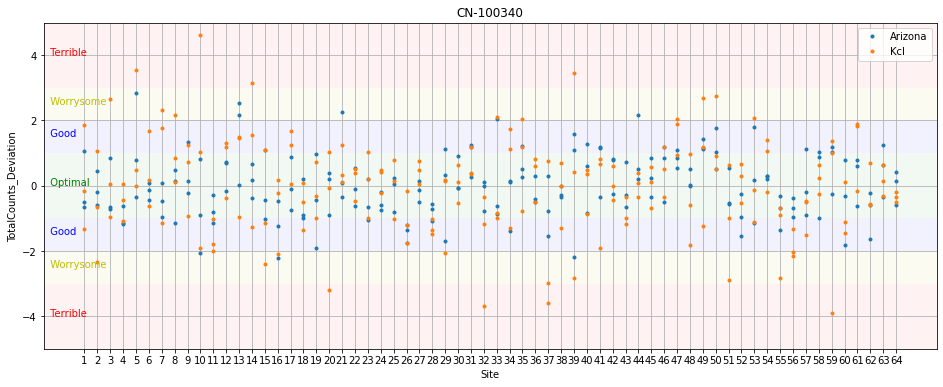

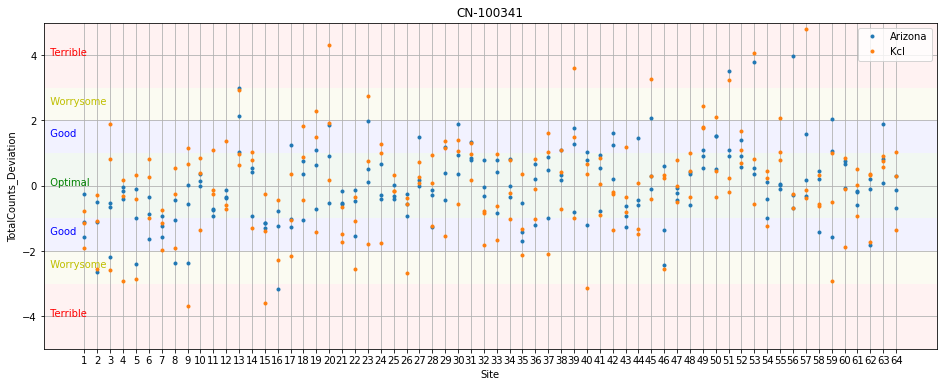

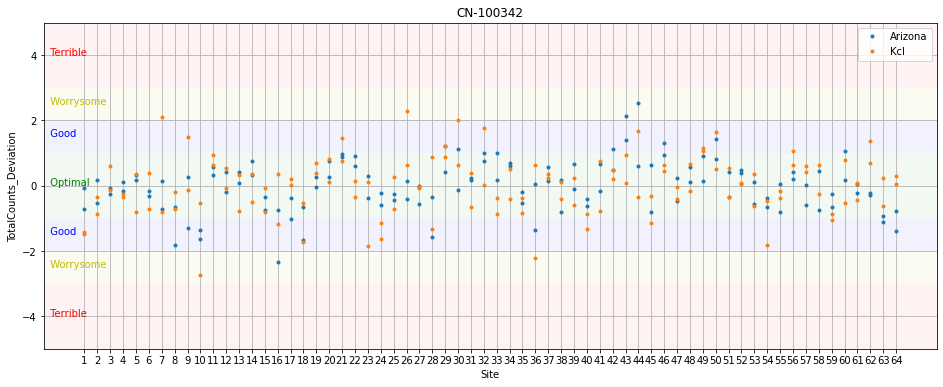

In [54]:
for idx, d in data4.groupby("FacilityNr"):
    fig, ax = plt.subplots(figsize=[16,6])
    for col, aerosol in zip(["Acc_1", "Acc_2"], ["Arizona", "Kcl"]):
        d.reset_index().plot(x="Site", y=col, ax=ax, label=aerosol, marker=".", linestyle="")
        
    _put_colored_bands(ax, [
        ("Terrible", [-5, -3], 'r'),
        ("Worrysome", [-3, -2], 'y'), 
        ("Good", [-2, -1], 'b'),
        ("Optimal", [-1, 1], 'g'), 
        ("Good", [1, 2], 'b'),
        ("Worrysome", [2, 3], 'y'), 
        ("Terrible", [3, 5], 'r')
    ])
    ax.set_title("{}".format(idx))
    ax.set_ylim([-5, 5])
    ax.legend()
    ax.set_xticks(range(1,65))
    ax.grid("on")
    ax.set_ylabel("TotalCounts_Deviation")
